**Введение** Представим, что вы хотите разработать модель, анализирующую тональность текста. 

Вы загрузили датасет...

In [0]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/esolovev/ling2019/master/module2/twi_data.csv', encoding='utf-8', sep=';').head(4000) #Инече падает

In [4]:
df.head()

,target,date,text
0,4,Tue Jun 02 02:59:24 PDT 2009,@JackAllTimeLow hope it went good! i couldnt m...
1,0,Sat Jun 06 00:25:20 PDT 2009,@SDI8732 Idk how to do it!!!
2,0,Fri Jun 05 12:07:23 PDT 2009,"@kmwindmill is here ! woop woop , would be bet..."
3,4,Mon Jun 01 14:55:06 PDT 2009,@Daydreamer1984 He explains the tailer better
4,0,Sat Jun 20 15:39:44 PDT 2009,still trying to get a pic on this twitter thin...


In [0]:
y = df['target'].replace(4, 1)

del df['date']
del df['target']

In [5]:
df.head()

,text
0,@JackAllTimeLow hope it went good! i couldnt m...
1,@SDI8732 Idk how to do it!!!
2,"@kmwindmill is here ! woop woop , would be bet..."
3,@Daydreamer1984 He explains the tailer better
4,still trying to get a pic on this twitter thin...


In [6]:
y

0        1
1        0
2        0
3        1
4        0
        ..
39995    1
39996    1
39997    1
39998    0
39999    0
Name: target, Length: 40000, dtype: int64

... выделили из него какие-то признаки ...

In [71]:
transformed_texts = CountVectorizer(stop_words='english',
                                    max_df=0.95,
                                    min_df=3,
                                    ngram_range=(1,3),
                                    analyzer='word',).\
                    fit_transform(df.text.values).\
                    toarray() #конвертируем из разреженной матрицы в обычную, потому что PCA в sklearn не поддерживает sparse матрицы

print(transformed_texts.shape)
transformed_texts

(4000, 1894)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

... и разделили выборку на обучающую и тестовую.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(transformed_texts, y, train_size=0.5, stratify=y, random_state=123)

А теперь посмотрим, как долго будет обучаться, например, случайный лес.

In [0]:
%%time

RandomForestClassifier(n_estimators=100, n_jobs=-1).fit(X_train, y_train)

CPU times: user 16min 41s, sys: 10.8 s, total: 16min 52s
Wall time: 3min 43s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

4 минуты - это слишком долго (причём это время обучения на 8-ядерном процессоре). 

А если уменьшить размерность?

In [0]:
%%time

pca = PCA(n_components=150)
reducted_train = pca.fit_transform(X_train)

CPU times: user 1min 37s, sys: 4.33 s, total: 1min 41s
Wall time: 55.9 s


In [0]:
reducted_train.shape

(20000, 150)

In [0]:
%%time

RandomForestClassifier(n_estimators=100, n_jobs=-1).fit(reducted_train, y_train)

CPU times: user 31.5 s, sys: 183 ms, total: 31.7 s
Wall time: 5.83 s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

Уже лучше (если мы один раз уменьшаем размерность, а затем обучаем много разных моделек на получившемся датасете, среднее время на обучение получается сильно лучше даже с учетом того, что мы потратили минуту на PCA). А вот посмотреть, насколько ухудшается или улучшается качество при использовании PCA - ваша задача.

*Совет*: можете сначала написать код для меньшего количества параметров, решающее все задание, отладить его, а уже потом запустить его на всех параметрах. Так вы сэкономите время, затрачиваемое на обучение.

**Задание 1**
Возьмите 5 различных значений для числа главных компонент в PCA. Для каждого из данных значений параметров решающего леса выберите лучшую модель с помощью GridSearchCV на 3 фолдах (**важно**: чтобы графики из второго задания были корректны, вам нужно, чтобы разбиение на фолды было одинаковое для всех значений числа компонент). Используйте accuracy как метрику качества.

* max_depth: 3, 6, 9, 12, 50
* n_estimators: 25, 50, 75, 100


**Задание 2**
Отобразите на одной картинке два графика (по оси X отложено число главных компонент в PCA):

1) Качество лучшей модели на тестовой выборке

2) Среднее качество на 3 фолдах при подборе параметров (для лучшей модели)

3) Общая доля объяснённой дисперсии для выбранного числа компонент (для лучшей модели).

In [73]:
pipeline = Pipeline([
    ('pca', PCA()),
    ('predict', RandomForestClassifier())
])

params = {
    'pca__n_components': [1, 2, 3, 4, 5], 
    'predict__max_depth': [3, 6, 9, 12, 50], 
    'predict__n_estimators': [25, 50, 75, 100] 
}

kf = KFold(n_splits=3, random_state = 35862)

grid = GridSearchCV(pipeline, params,cv=kf)
grid_result = grid.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [18]:
# model = RandomForestClassifier( n_estimators = grid_result.best_params_['predict__n_estimators'],max_depth = grid_result.best_params_['predict__max_depth'] )
# pca = PCA(n_components= grid_result.best_params_['pca__n_components'])
# reducted_train = pca.fit_transform(X_train)
# reducted_test = pca.fit_transform(X_test)
# model.fit(reducted_train, y_train)
# print('Accuracy: ',model.score(reducted_test,y_test))

Accuracy:  0.5833333333333334


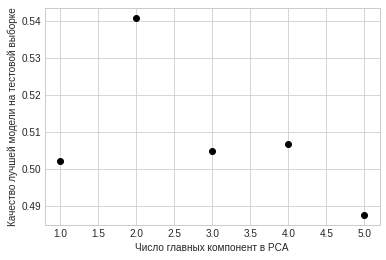

In [59]:
# import matplotlib.pyplot as plt
# scores =[]
# for x in [1, 2, 3, 4, 5]:
#   model = RandomForestClassifier( n_estimators = grid_result.best_params_['predict__n_estimators'],max_depth = grid_result.best_params_['predict__max_depth'], random_state = 54345)
#   pca = PCA(n_components= x)
#   reducted_train = pca.fit_transform(X_train)
#   reducted_test = pca.fit_transform(X_test)
#   model.fit(reducted_train, y_train)
#   scores.append(model.score(reducted_test,y_test))


# plt.style.use('seaborn-whitegrid')
# x = [1, 2, 3, 4, 5]
# y = scores
# plt.ylabel('Качество лучшей модели на тестовой выборке')
# plt.xlabel('Число главных компонент в PCA')
# plt.plot(x, y, 'o', color='black');

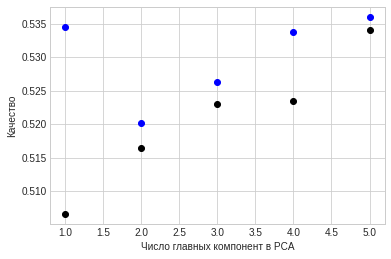

In [91]:
import statistics
means = [] 
max_cross = []
ratio = []

for x in [1, 2, 3, 4, 5]:
  model = RandomForestClassifier( n_estimators = grid_result.best_params_['predict__n_estimators'],max_depth = grid_result.best_params_['predict__max_depth'], random_state = 54345)
  pca = PCA(n_components= x)
  reducted_train = pca.fit_transform(X_train)
  reducted_test = pca.fit_transform(X_test)
  cross = cross_val_score(model, reducted_train, y_train, cv=kf)
  max_cross.append(max(cross))
  mean = statistics.mean(cross) 
  means.append(mean)

  ratio.append(pca.explained_variance_ratio_.mean())


plt.style.use('seaborn-whitegrid')
x = [1, 2, 3, 4, 5]
y = means
plt.ylabel('Качество')
plt.xlabel('Число главных компонент в PCA')
plt.plot(x, y, 'o', color='black');

plt.style.use('seaborn-whitegrid')
x = [1, 2, 3, 4, 5]
y = max_cross
plt.ylabel('Качество')
plt.xlabel('Число главных компонент в PCA')
plt.plot(x, y, 'o', color='blue');




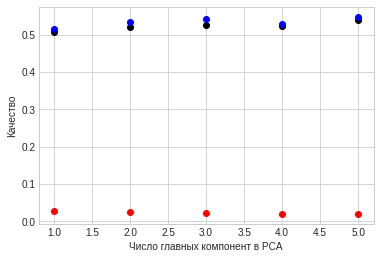

In [90]:
#когда появляется третий график, некрасиво получается
plt.style.use('seaborn-whitegrid')
x = [1, 2, 3, 4, 5]
y = means
plt.ylabel('Качество')
plt.xlabel('Число главных компонент в PCA')
plt.plot(x, y, 'o', color='black');

plt.style.use('seaborn-whitegrid')
x = [1, 2, 3, 4, 5]
y = max_cross
plt.ylabel('Качество')
plt.xlabel('Число главных компонент в PCA')
plt.plot(x, y, 'o', color='blue');

plt.style.use('seaborn-whitegrid')
x = [1, 2, 3, 4, 5]
y = ratio
plt.ylabel('Качество')
plt.xlabel('Число главных компонент в PCA')
plt.plot(x, y, 'o', color='red');